# Использование модели BERTopic для извлечения ключевых слов из предложения

## 0 Подготовительный этап

In [ ]:
!pip install -q pdfplumber
!pip install -q spacy==3.2.1
!python -m spacy download ru_core_news_lg
!pip install -q pymorphy2
!pip install nltk

In [ ]:
import os
import re
from string import punctuation
from typing import List, Tuple

import pdfplumber
import spacy
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from pymorphy2 import MorphAnalyzer

In [ ]:
import nltk
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1 Сбор и подготовка данных

Для обучения предобработаем несколько книг по программированию

Использованные книги: [тык](https://drive.google.com/drive/folders/1KE3oCJ3fO9Xt3qrbQPD4pWFLw3wsUE55?usp=sharing)

### Конвертирование pdf в очищенные txt файлы

In [ ]:
books_dir = '/content/drive/MyDrive/ОмГТУ/Диплом/books'
base_dir, dirs, _ = list(os.walk(books_dir))[0]

pdf_dir = os.path.join(base_dir, dirs[dirs.index('pdf')])
txt_dir = os.path.join(base_dir, dirs[dirs.index('txt')])
clean_dir = os.path.join(base_dir, dirs[dirs.index('clean')])

pdf_paths = [
    os.path.join(pdf_dir, filename) for filename in list(os.walk(pdf_dir))[0][-1]
]
txt_paths = [
    os.path.join(txt_dir, filename.rsplit('.', maxsplit=1)[0] + '.txt')
    for filename in list(os.walk(pdf_dir))[0][-1]
]
txt_clean_paths = [
    os.path.join(clean_dir, filename.rsplit('.', maxsplit=1)[0] + '_clean.txt')
    for filename in list(os.walk(pdf_dir))[0][-1]
]

In [ ]:
print(*pdf_paths, sep='\n')

In [ ]:
def save_as_txt(pdf_path: str, txt_path: str) -> None:
    with open(file=txt_path, mode='w', encoding='utf8') as outfile:
        with pdfplumber.open(pdf_path) as pdf:
            for page in pdf.pages:
                outfile.write(page.extract_text(x_tolerance=2))

In [ ]:
%%time
for path, txt_path in zip(pdf_paths, txt_paths):
    if not os.path.isfile(txt_path):
        save_as_txt(path, txt_path)

CPU times: user 29min 51s, sys: 16.4 s, total: 30min 7s
Wall time: 30min 8s


In [ ]:
RU_MODEL = spacy.load('ru_core_news_lg')
STOPWORDS = stopwords.words('russian') + stopwords.words('english')
PUNC = [symbol for symbol in punctuation + "–"]

In [ ]:
def preprocess_text(raw_text: str) -> List[str]:
    # удалим цифры, переносы строк, лишние пробелы
    clean_text = re.sub(r"\s+", " ", re.sub(r"\d+", "", raw_text))
    # лемматизация и токенизация
    base_tokens = [token.lemma_ for token in RU_MODEL(clean_text)]
    # удаление стоп-слов
    return [
        token for token in base_tokens 
        if token not in STOPWORDS and len(token) > 1 and \
        len([1 for symbol in PUNC if symbol in token.strip()]) == 0
    ]

In [ ]:
%%time
for txt_path, txt_clean_path in zip(txt_paths, txt_clean_paths):
    if not os.path.isfile(txt_clean_path):
        with open(txt_path, encoding='utf-8') as reader:
            with open(file=txt_clean_path, mode='w', encoding='utf-8') as writer:
                for line in reader.readlines():
                    writer.write(' '.join(preprocess_text(line)) + '\n')

### Создание датасета для BERTopic

In [ ]:
txt_clean_paths = [
    '/content/drive/MyDrive/ОмГТУ/Диплом/books/clean/' + str(i) + '.txt'
    for i in range(len(txt_paths))
]
dataset = []
for path in txt_clean_paths:
    with open(file=path, mode='r', encoding='utf-8') as infile:
        dataset.append(
            ' '.join(
                map(lambda line: line.replace('\n', ' '), infile.readlines())
            )
        )
        # batch = []
        # while len(batch) < batch_size:
        #     batch.extend(infile.readline())
        #     if len(batch) > batch_size:
        #         dataset.append(' '.join(batch))
        #         batch = []

In [ ]:
batch_size = 250
batched_dataset = []
for doc in dataset:
    splitted = doc.split()
    for i in range(len(splitted) // batch_size):
        batched_dataset.append(
            ' '.join(splitted[i * batch_size:(i + 1) * batch_size])
        )

## 2 Тематическое моделирование

In [ ]:
!pip install -q bertopic

     |████████████████████████████████| 57 kB 2.6 MB/s 
     |████████████████████████████████| 5.2 MB 10.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 79 kB 7.6 MB/s 
     |████████████████████████████████| 88 kB 5.7 MB/s 
     |████████████████████████████████| 4.0 MB 33.5 MB/s 
     |████████████████████████████████| 1.2 MB 38.3 MB/s 
     |████████████████████████████████| 77 kB 6.0 MB/s 
     |████████████████████████████████| 895 kB 42.8 MB/s 
     |████████████████████████████████| 6.6 MB 23.4 MB/s 
     |████████████████████████████████| 636 kB 48.6 MB/s 
     |████████████████████████████████| 1.1 MB 37.8 MB/s 


In [ ]:
from bertopic import BERTopic


params = {
    'language': 'russian',
    'n_gram_range': (1, 1),
    'top_n_words': 10,
    'min_topic_size': 10,
    'nr_topics': None,
    'low_memory': False,
    'calculate_probabilities': False,
    'diversity': None,
    'seed_topic_list': None,
    'embedding_model': None,
    'umap_model': None,
    'hdbscan_model': None,
    'vectorizer_model': None,
    'verbose': False,
}
topic_model = BERTopic(**params).fit(batched_dataset)

Downloading:   0%|          | 0.00/968 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.79k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/645 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/471M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/480 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/14.8M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [ ]:
len(topic_model.get_topics())

In [ ]:
topic_model.visualize_barchart(top_n_topics=20, n_words=10)

In [ ]:
competences_mapping = {
    '02.03.02': {
        'ОПК-1': 'Способен применять фундаментальные знания, полученные в области математических и (или) естественных наук, и использовать их в профессиональной деятельности',
        'ОПК-2': 'Способен применять компьютерные/суперкомпьютерные методы, современное программное обеспечение, в том числе отечественного происхождения, для решения задач профессиональной деятельности',
        'ОПК-3': 'Способен к разработке алгоритмических и программных решений в области системного и прикладного программирования, математических, информационных и имитационных моделей, созданию информационных ресурсов глобальных сетей, образовательного контента, прикладных баз данных, тестов и средств тестирования систем и средств на соответствие стандартам и исходным требованиям',
        'ОПК-4': 'Способен участвовать в разработке технической документации программных продуктов и комплексов с использованием стандартов, норм и правил, а также в управлении проектами создания информационных систем на стадиях жизненного цикла',
        'ОПК-5': 'Способен инсталлировать и сопровождать программное обеспечение информационных систем и баз данных, в том числе отечественного происхождения, с учетом информационной безопасности',
        'ОПК-6': 'Способен понимать принципы работы современных информационных технологий и использовать их для решения задач профессиональной деятельности'
    },
    '02.03.03': {
        'ОПК-1': 'Способен применять фундаментальные знания, полученные в области математических и (или) естественных наук, и использовать их в профессиональной деятельности',
        'ОПК-2': 'Способен применять современный математический аппарат, связанный с проектированием, разработкой, реализацией и оценкой качества программных продуктов и программных комплексов в различных областях человеческой деятельности',
        'ОПК-3': 'Способен понимать и применять современные информационные технологии, в том числе отечественные, при создании программных продуктов и программных комплексов различного назначения',
        'ОПК-4': 'Способен участвовать в разработке технической документации программных продуктов и программных комплексов',
        'ОПК-5': 'Способен инсталлировать и сопровождать программное обеспечение для информационных систем и баз данных, в том числе отечественного производства',
        'ОПК-6': 'Способен использовать в педагогической деятельности научные основы знаний в сфере информационно-коммуникационных технологий' 
    }
}

In [ ]:
def topics_of_competence(competence, topic_model) -> Tuple[List[int], List[Tuple[str, float]]]:
    topics, _ = topic_model.transform(competence)
    return topics, [topic_model.get_topic(topic) for topic in topics]

In [ ]:
for track in competences_mapping:
    competences = competences_mapping[track].values()
    for competence in competences:
        print(f'Компетенция: {competence}')
        topics, keywords = topics_of_competence(competence, topic_model)
        for t, kw in zip(topics, keywords):
            print(f'Topic: {t}')
            print('Keywords:')
            print(*kw, sep='\n')
            print('-' * 125)
        print('*' * 125)

Компетенция: Способен применять фундаментальные знания, полученные в области математических и (или) естественных наук, и использовать их в профессиональной деятельности
Topic: 1
Keywords:
('сейбел', 0.01999293625569746)
('это', 0.016234327940748364)
('год', 0.014716680450564191)
('компьютер', 0.013136147382532744)
('программист', 0.012807688700128172)
('программирование', 0.012701074690476228)
('программа', 0.01254281689898809)
('работать', 0.012326484002527541)
('человек', 0.011994797787391627)
('заниматься', 0.010424565623945645)
-----------------------------------------------------------------------------------------------------------------------------
*****************************************************************************************************************************
Компетенция: Способен применять компьютерные/суперкомпьютерные методы, современное программное обеспечение, в том числе отечественного происхождения, для решения задач профессиональной деятельности
Topic: -1
Ke

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  app.launch_new_instance()
No handles with labels found to put in legend.


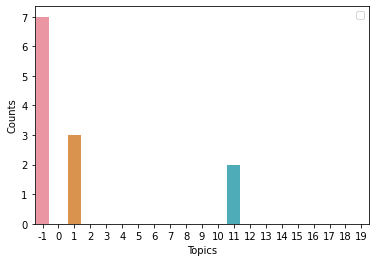

In [ ]:
import seaborn as sns
import numpy as np



labels = list(range(-1, 20))
x = range(len(labels))
y = [7, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0]

ax = sns.barplot(
    x=labels,
    y=y
)
ax.set_ylabel('Counts')
ax.set_xlabel('Topics')
ax.set_xticks(x, labels)
ax.legend()

## -1 Temp

In [ ]:
import numpy as np
from scipy import stats
from sklearn.datasets import fetch_20newsgroups
docs = fetch_20newsgroups(subset='all')['data']
lens = [len(doc.split()) for doc in docs]
lens.sort()
print('Mean:', np.mean(lens))
print('Median:', np.median(lens))
print('Mode:', stats.mode(lens).mode[0])